Azad Rasul: azad.rasul@soran.edu.iq. Attribution: The code was inspired by the DroneMapper CropAnalysis project: https://github.com/dronemapper-io/CropAnalysis 

#### Introduction:

In this tutorial, we explore the use of computer vision techniques to detect and count plants using raster data. By leveraging tools like OpenCV, rasterio, and EarthPy, we process raster datasets to identify and visualize plant locations. The method employs blob detection to count plants within a specified plot area accurately, providing valuable insights for applications in agriculture and environmental monitoring.

#### Data Download
Download the data from: DroneMapper Crop Analysis Data (https://github.com/dronemapper-io/CropAnalysis) and extract it into the data/ directory of your notebook.

In [1]:
# Import libraries for geospatial data handling
import geopandas as gpd  # GeoPandas is used for reading and handling geospatial data

# Import numerical and array operations libraries
import numpy as np  # NumPy is used for numerical computations and array manipulation

# Import libraries for handling and processing raster data
import rasterio  # Rasterio is used for reading and writing raster data
from rasterio.mask import mask  # Mask function from rasterio is used for masking raster data using vector geometries

# Import libraries for plotting and data visualization
import matplotlib.pyplot as plt  # Matplotlib is used for creating static and interactive plots
import earthpy.plot as ep  # EarthPy is used for plotting and visualizing raster and vector data

# Import OpenCV for computer vision tasks
import cv2  # OpenCV is used for image processing and computer vision tasks

# Import Pandas for data manipulation and analysis
import pandas as pd  # Pandas is used for handling and analyzing data in DataFrame format


In [2]:
def read_plot_data(file_path):
    """Read the plot data from a shapefile.

    Args:
        file_path (str): The path to the shapefile containing plot data.

    Returns:
        GeoDataFrame: A GeoDataFrame containing the plot data.

    Raises:
        FileNotFoundError: If the shapefile cannot be read or found.
    """
    try:
        # Use geopandas to read the shapefile and load it into a GeoDataFrame
        return gpd.read_file(file_path)
    except Exception as e:
        # If there is an error reading the file, raise a FileNotFoundError with a descriptive message
        raise FileNotFoundError(f"Error reading plot data: {e}")


In [3]:
def load_raster(file_path):
    """
    Load raster data from a file using rasterio.

    Args:
        file_path (str): Path to the raster file.

    Returns:
        rasterio.io.DatasetReader: An object representing the raster data.

    Raises:
        FileNotFoundError: If the file cannot be found or read.
    """
    try:
        # Open the raster file and return the dataset object
        return rasterio.open(file_path)
    except Exception as e:
        # If an error occurs, raise a FileNotFoundError with a descriptive message
        raise FileNotFoundError(f"Error loading raster data: {e}")


In [4]:
def mask_raster_with_plot(raster, plot):
    """Mask the raster data with the plot extent."""
    try:
        # Apply the mask to the raster data using the geometry from the plot shapefile
        # 'crop=True' ensures that the raster is cropped to the plot's extent
        clip, transform = mask(raster, plot.geometry, crop=True)

        # Convert the masked raster data to float32 to accommodate NaN values
        # This is necessary because some raster operations might result in values that are not valid (e.g., 0 or negative values)
        clip = clip.astype('float32')

        # Replace all values less than or equal to 0 with NaN
        # This step is used to filter out any non-positive values which might be considered invalid or not useful
        clip[clip <= 0] = np.nan

        # Return the processed raster data and the transformation matrix
        return clip, transform
    except Exception as e:
        # Handle any errors that occur during the masking process and raise a runtime error with a descriptive message
        raise RuntimeError(f"Error masking raster data: {e}")


In [5]:
def generate_plant_model(dem_clip, dtm_clip):
    """
    Generate a plant model by calculating the difference between the DEM (Digital Elevation Model) and the DTM (Digital Terrain Model).
    
    Parameters:
    dem_clip (numpy.ndarray): Clipped DEM data, representing the elevation of the ground surface.
    dtm_clip (numpy.ndarray): Clipped DTM data, representing the elevation of the bare earth surface.
    
    Returns:
    numpy.ndarray: A plant model where the difference between DEM and DTM is used to identify areas where plants are likely to be present.
    """
    # Calculate the plant model by subtracting the DTM from the DEM
    # This highlights the vegetation or structures by removing the underlying terrain elevation
    plant_model = dem_clip - dtm_clip
    
    # Apply a threshold to filter out small or insignificant values
    # Values less than or equal to 0.20 are set to NaN to exclude areas with little to no vegetation
    plant_model[plant_model <= 0.20] = np.nan
    
    return plant_model


In [6]:
def plot_plant_model_and_binary(plant_model, binary_image, plot_extent):
    """Plot the plant model and binary image."""
    
    # Create a figure with two subplots arranged in one row and two columns
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))

    # Check if plant_model has more than one dimension (i.e., it's a valid image array)
    if plant_model.ndim > 0:
        # Plot the plant model on the first subplot (ax[0])
        # Use EarthPy's plot_bands function to visualize the plant model with a terrain color map
        ep.plot_bands(
            plant_model[0],  # Use the first band of the plant model
            ax=ax[0],        # Specify the subplot axis
            scale=False,     # Disable scaling to maintain original values
            cmap="terrain",  # Apply the 'terrain' color map for visualization
            title="Plant Model",  # Set the title of the subplot
            extent=plot_extent  # Define the spatial extent for the plot
        )
    
    # Plot the binary image on the second subplot (ax[1])
    # Use EarthPy's plot_bands function to visualize the binary mask with a binary color map
    ep.plot_bands(
        binary_image,       # The binary image to plot
        ax=ax[1],           # Specify the subplot axis
        scale=False,        # Disable scaling to maintain original values
        cmap="binary",      # Apply the 'binary' color map for visualization
        title="Binary Plant Mask",  # Set the title of the subplot
        extent=plot_extent  # Define the spatial extent for the plot
    )
    
    # Display the plot with the two subplots
    plt.show()


In [7]:
def setup_blob_detector():
    """Setup the SimpleBlobDetector with parameters to detect blobs in an image."""
    # Create an instance of SimpleBlobDetector_Params to configure the blob detector
    params = cv2.SimpleBlobDetector_Params()
    
    # Set the minimum distance between detected blobs
    params.minDistBetweenBlobs = 10  
    # Increasing this value reduces the number of detected blobs, 
    # as it prevents close blobs from being detected as separate entities

    # Configure color filtering for blob detection
    params.filterByColor = False
    # Set to True if you need to filter blobs by color; however, it's typically not used for RGB images
    params.blobColor = 255  # Blob color value; relevant only if filterByColor is True

    # Configure area filtering for blob detection
    params.filterByArea = True
    # Enable filtering based on the size (area) of the detected blobs
    params.minArea = 50  # Minimum area of blobs to be detected; adjust to ignore smaller blobs
    params.maxArea = 3000  # Maximum area of blobs to be detected; adjust to ignore larger blobs

    # Configure circularity filtering for blob detection
    params.filterByCircularity = True
    # Enable filtering based on the circularity of the detected blobs
    params.minCircularity = 0.7  # Minimum circularity to consider; blobs closer to 1 are more circular

    # Configure convexity filtering for blob detection
    params.filterByConvexity = True
    # Enable filtering based on the convexity of the detected blobs
    params.minConvexity = 0.5  # Minimum convexity to consider; a value of 1 means the blob is perfectly convex

    # Configure inertia filtering for blob detection
    params.filterByInertia = True
    # Enable filtering based on the inertia ratio of the detected blobs
    params.minInertiaRatio = 0.1  # Minimum inertia ratio to consider; filters out blobs with too high or too low inertia
    params.maxInertiaRatio = 1.0  # Maximum inertia ratio to consider; blobs with high or low inertia are filtered out

    # Return a SimpleBlobDetector instance with the specified parameters
    return cv2.SimpleBlobDetector_create(params)


In [8]:
def detect_plants(binary_image_int, rgb):
    """Detect plant keypoints in the binary image."""

    # Setup the blob detector with specified parameters
    detector = setup_blob_detector()

    # Resize the binary image to match the dimensions of the RGB image
    # This ensures that the blob detector can accurately process the binary image
    binary_image_int = cv2.resize(
        binary_image_int,                # Input binary image
        dsize=(rgb.shape[1], rgb.shape[0]),  # Desired output size matching RGB image dimensions
        interpolation=cv2.INTER_CUBIC     # Interpolation method for resizing (Cubic interpolation is used for smoother results)
    )

    # Detect keypoints (blobs) in the resized binary image using the blob detector
    keypoints = detector.detect(binary_image_int)

    # Return the detected keypoints for further processing or visualization
    return keypoints


In [9]:
def plot_plant_count(rgb, keypoints):
    """Plot the plant count on the RGB image with blue circles."""
    
    # Ensure the RGB image values are within the range [0, 255] and convert to uint8
    # This step is crucial to make sure that the image is displayed correctly.
    rgb = np.clip(rgb, 0, 255).astype(np.uint8)

    # Draw keypoints on the RGB image
    # cv2.drawKeypoints is used to overlay detected keypoints onto the RGB image.
    # The color (255, 0, 0) represents blue in BGR format, and we use DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    # to draw circles around keypoints with additional information like size.
    plants_with_keypoints = cv2.drawKeypoints(
        rgb,                      # The input RGB image
        keypoints,                # Detected keypoints
        np.array([]),             # An empty array for output images, not used here
        (255, 0, 0),              # Blue color in BGR format
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Draw rich keypoints with additional information
    )

    # Create a plot to display the image
    fig, ax = plt.subplots(figsize=(10, 10))  # Create a new figure and axes with specified size
    ax.imshow(cv2.cvtColor(plants_with_keypoints, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying in matplotlib
    ax.set_title("Detected Plants with Blue Circles")  # Set the title for the plot
    plt.axis('off')  # Hide the axis to focus on the image
    plt.show()  # Display the plot


In [10]:
def normalize_rgb(image):
    """Normalize RGB image data to the range [0, 255]."""
    image = image.astype(float)
    image -= np.min(image)  # Shift to start from 0
    image /= np.max(image)  # Scale to 0-1
    image *= 255  # Scale to 0-255
    return image.astype(np.uint8)

def build_true_color_image(rgb_clip):
    """Ensure RGB values are correctly scaled for true color representation."""
    # Ensure the data is in the correct range
    rgb = np.stack((rgb_clip[0], rgb_clip[1], rgb_clip[2]), axis=-1)
    rgb = np.clip(rgb, 0, 255)  # Clip values to ensure they are within the 0-255 range
    return rgb.astype(np.uint8)  # Convert to uint8 for true color representation


In [11]:
def extract_plant_coordinates(keypoints, ortho):
    """
    Extract the geographic coordinates of detected plant keypoints from the raster data.
    
    Parameters:
    - keypoints: A list of keypoints detected by the blob detector, each representing a detected plant.
    - ortho: The raster dataset (orthophoto) used to convert pixel locations to geographic coordinates.
    
    Returns:
    - A dictionary with plant indices as keys and their geographic coordinates (UTM X, UTM Y) as values.
    """
    plant_coordinates = {}  # Initialize an empty dictionary to store plant coordinates
    for i, keypoint in enumerate(keypoints):
        # Convert the pixel coordinates of the keypoint to geographic coordinates
        plant_center = ortho.xy(keypoint.pt[0], keypoint.pt[1])
        # Store the geographic coordinates in the dictionary with the plant index
        plant_coordinates[i] = [plant_center[0], plant_center[1]]
    return plant_coordinates

In [12]:
def save_plant_coordinates_to_csv(plant_coordinates, file_path):
    """
    Save the extracted plant coordinates to a CSV file for further analysis or reporting.
    
    Parameters:
    - plant_coordinates: A dictionary with plant indices and their geographic coordinates.
    - file_path: The path where the CSV file will be saved.
    
    Returns:
    - A DataFrame containing the plant coordinates, which is also saved to a CSV file.
    """
    # Convert the dictionary of plant coordinates to a pandas DataFrame
    plant_df = pd.DataFrame.from_dict(plant_coordinates, orient='index', columns=['UTMX', 'UTMY'])
    # Save the DataFrame to a CSV file
    plant_df.to_csv(file_path, index=False)
    return plant_df  # Return the DataFrame for potential further use

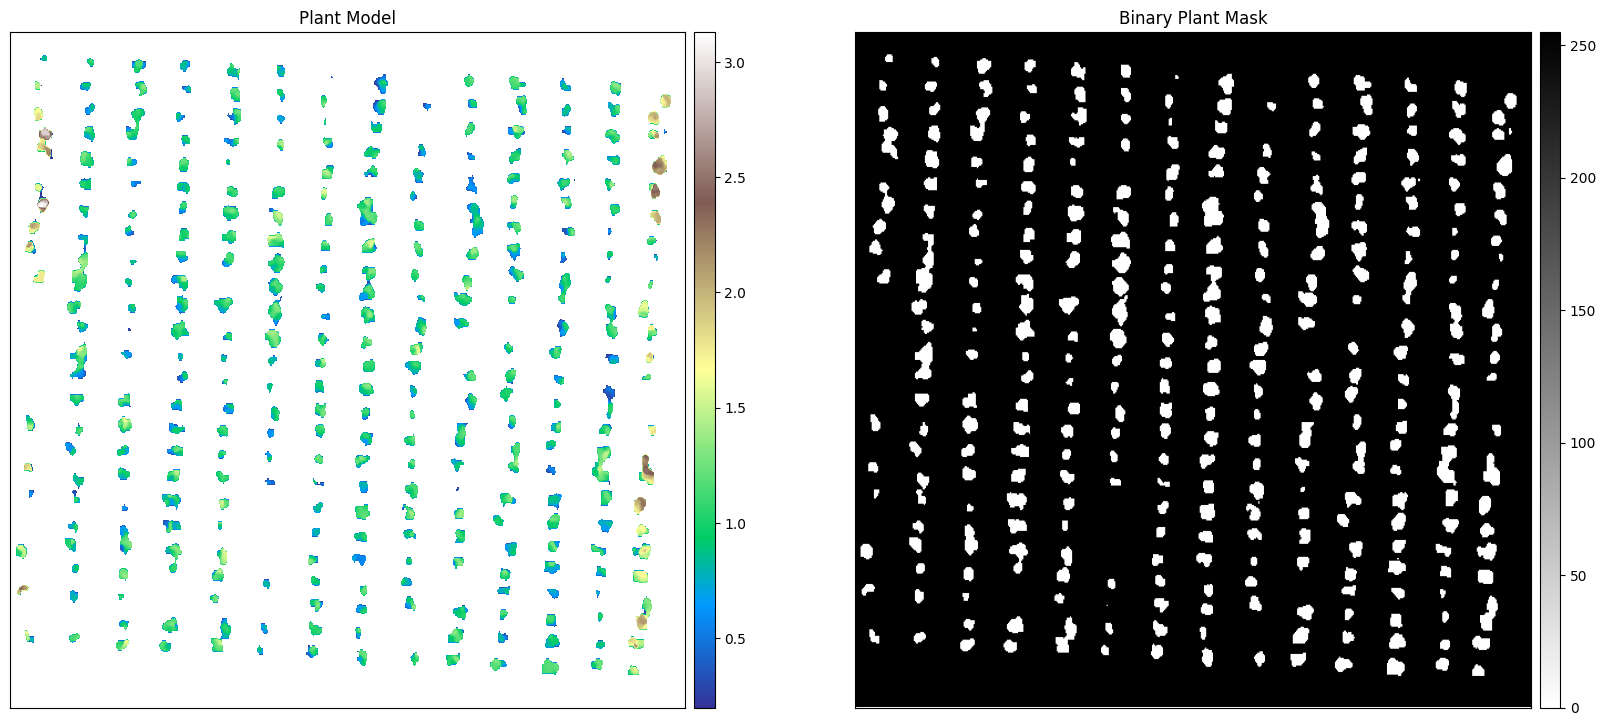

Plant count: 270


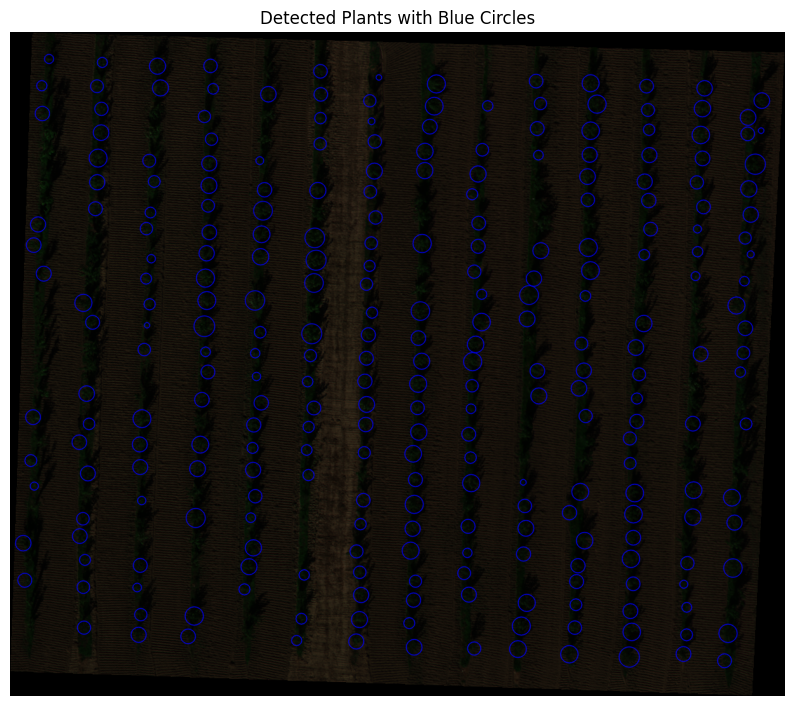

In [13]:
def main():
    # Load plot data from shapefile
    # This file contains vector data defining the area of interest for plant detection
    plot = read_plot_data('data/plant_count.shp')

    # Load raster datasets
    # Datasets include Digital Terrain Model (DTM), Digital Elevation Model (DEM), and Orthophoto (orthophoto)
    dtm = load_raster('data/dtm.tif')
    dem = load_raster('data/dem.tif')
    ortho = load_raster('data/ortho.tif')

    # Mask the raster datasets to the plot extent
    # This process clips the raster data to the region defined by the shapefile, focusing the analysis on the area of interest
    dtm_clip, _ = mask_raster_with_plot(dtm, plot)
    dem_clip, _ = mask_raster_with_plot(dem, plot)
    rgb_clip, _ = mask_raster_with_plot(ortho, plot)

    # Normalize RGB data and build true color image
    rgb_clip = np.nan_to_num(rgb_clip, nan=0)
    rgb_clip = normalize_rgb(rgb_clip)
    rgb = build_true_color_image(rgb_clip)

    # Generate the plant model by subtracting DTM from DEM
    # This model helps in identifying vegetation by highlighting areas with significant elevation changes
    plant_model = generate_plant_model(dem_clip, dtm_clip)

    # Create a binary image for plant detection
    # The binary image is created by setting pixels above a threshold to 255 (white) and below the threshold to 0 (black)
    binary_image = 255 * (plant_model[0] > 0)
    binary_image_int = cv2.bitwise_not(binary_image.astype(np.uint8))  # Invert the binary image

    # Plot the plant model and binary image
    # Visualize the plant model and the resulting binary mask side by side for comparison
    plot_plant_model_and_binary(plant_model, binary_image_int, plot.total_bounds)
    
    # Detect plants in the binary image
    # Use blob detection to identify plant locations within the binary mask
    keypoints = detect_plants(binary_image_int, rgb)
    print(f'Plant count: {len(keypoints)}')  # Print the total number of detected plants

    # Plot the detected plants on the true color image
    # Display the RGB image with blue circles marking detected plants
    plot_plant_count(rgb, keypoints)

    # Extract plant coordinates from the detected keypoints
    # Convert keypoint positions to geographical coordinates using the orthophoto's coordinate reference system
    plant_coordinates = extract_plant_coordinates(keypoints, ortho)

    # Save the plant coordinates to a CSV file
    # This file will contain the geographical coordinates of detected plants for further analysis
    plant_df = save_plant_coordinates_to_csv(plant_coordinates, 'output/plant_count.csv')
    # Uncomment the line below to display the first few rows of the plant coordinates dataframe
    # display(plant_df.head())

# Ensure the main function is called when the script is executed directly
if __name__ == "__main__":
    main()


#### Conclusion:

In this tutorial, we successfully implemented a computer vision approach to detect plants in raster data. By using blob detection, we were able to identify and visualize plant locations, providing valuable insights for agricultural analysis. This method can be further refined and adapted to various datasets and detection requirements, making it a versatile tool in precision agriculture and environmental monitoring.